# 프로젝트: Spectrogram classification 모델 구현

목표 : 2차원 Spectrogram 데이터를 입력받아 모델을 기본 버전과 Skip-connection 버전으로 나누어 훈련 시킨후, 테스트 데이터로 예측 결과를 확인한다. 

## 1. 데이터 처리와 분류

라벨 데이터 처리하기  
sklearn의 train_test_split함수를 이용하여 train, test 분리  

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


### 데이터 크기 조절

In [2]:
speech_data_vals = speech_data["wav_vals"][:30000]

In [3]:
speech_data_label = speech_data["label_vals"][:30000]

### label에 index 부여 후 label_data 생성

In [4]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [5]:
temp = []
for v in speech_data_label:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([3, 3, 3, ..., 7, 7, 7])

###  음성데이터를 2차원 Spectrogram 으로 변환

In [6]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [7]:
temp2 = []
for v in speech_data_vals:
    temp2.append(wav2spec(v))
    
speech_data_spec = np.array(temp2)
speech_data_spec.shape   

(30000, 130, 126)

### train 과 test 데이터 분리 

In [8]:
from sklearn.model_selection import train_test_split

train_wav, test_wav, train_label, test_label = train_test_split(speech_data_spec, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
train_wav = train_wav.reshape([-1,  130, 126, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1,  130, 126, 1])
print("✅")

✅


In [9]:
train_wav.shape

(27000, 130, 126, 1)

In [9]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (27000, 130, 126, 1)
train labels :  (27000,)
test data :  (3000, 130, 126, 1)
test labels :  (3000,)
✅


## 2. 학습을 위한 하이퍼파라미터 설정

In [9]:
batch_size = 64
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/ssac6/aiffel/speech_recognition/models/wav'

**Callback**  
model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정할 수 있습니다.  
모델을 재사용하기위해서 모델 가중치를 저장하는 callback 함수를 추가  

In [10]:
import tensorflow as tf
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


## 3. 데이터셋 구성
tf.data.Dataset을 이용  
from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용  
map과 batch를 이용한 데이터 전처리  

In [11]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [12]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


In [13]:
del speech_data
del speech_data_spec

## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

### 4-1. 기본 버전으로 모델 생성 
2차원 Spectrogram 데이터를 입력 Conv2D layer를 적용

In [14]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model2 = tf.keras.Model(input_tensor, output_tensor)

model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

In [15]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


### 4-2. Skip-Connection 모델 생성
2차원 Spectrogram 데이터를 입력 Conv2D layer를 적용

In [15]:
from tensorflow.keras import layers
input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 130, 126, 32) 2624        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 130, 126, 32) 82976       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 63, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [16]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

모델 학습 후, loss, accuracy를 그래프로 표현  

### 5-1. 기본 버전 모델 학습과 결과 그래프

### (기본 버전) 모델 학습

In [16]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav2 = model2.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
421/421 [==============================] - ETA: 0s - loss: 0.8409 - accuracy: 0.7101
Epoch 00001: val_loss improved from inf to 0.42386, saving model to /home/ssac6/aiffel/speech_recognition/models/wav
421/421 [==============================] - 105s 248ms/step - loss: 0.8409 - accuracy: 0.7101 - val_loss: 0.4239 - val_accuracy: 0.8906
Epoch 2/10
421/421 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9216
Epoch 00002: val_loss improved from 0.42386 to 0.18375, saving model to /home/ssac6/aiffel/speech_recognition/models/wav
421/421 [==============================] - 99s 235ms/step - loss: 0.2403 - accuracy: 0.9216 - val_loss: 0.1838 - val_accuracy: 0.9412
Epoch 3/10
421/421 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9489
Epoch 00003: val_loss improved from 0.18375 to 0.16652, saving model to /home/ssac6/aiffel/speech_recognition/models/wav
421/421 [==============================] - 107s 253ms/step - loss: 0.1555 - accuracy

### (기본 버전) loss, accuracy를 그래프로 표현

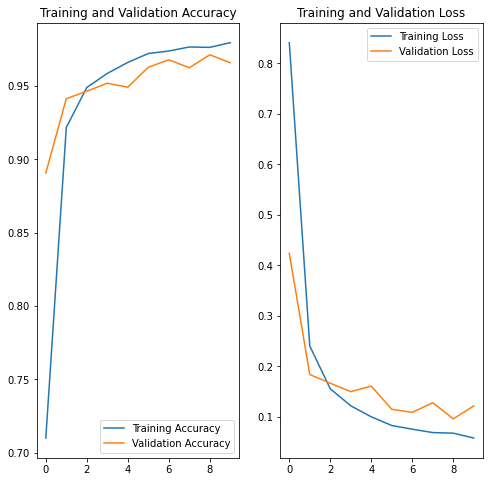

✅


In [17]:
import matplotlib.pyplot as plt

acc2 = history_wav2.history['accuracy']
val_acc2 = history_wav2.history['val_accuracy']

loss2=history_wav2.history['loss']
val_loss2=history_wav2.history['val_loss']

epochs_range2 = range(len(acc2))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range2, acc2, label='Training Accuracy')
plt.plot(epochs_range2, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range2, loss2, label='Training Loss')
plt.plot(epochs_range2, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
print("✅")

### 5-2. Skip-Connection 모델 학습과 결과 그래프

### ( Skip-Connection ) 모델 학습

In [17]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav1 = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
421/421 [==============================] - ETA: 0s - loss: 0.8752 - accuracy: 0.7085
Epoch 00001: val_loss improved from inf to 0.31052, saving model to /home/ssac6/aiffel/speech_recognition/models/wav
421/421 [==============================] - 101s 241ms/step - loss: 0.8752 - accuracy: 0.7085 - val_loss: 0.3105 - val_accuracy: 0.8971
Epoch 2/10
421/421 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9277
Epoch 00002: val_loss improved from 0.31052 to 0.19906, saving model to /home/ssac6/aiffel/speech_recognition/models/wav
421/421 [==============================] - 102s 242ms/step - loss: 0.2206 - accuracy: 0.9277 - val_loss: 0.1991 - val_accuracy: 0.9310
Epoch 3/10
421/421 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9558
Epoch 00003: val_loss improved from 0.19906 to 0.19850, saving model to /home/ssac6/aiffel/speech_recognition/models/wav
421/421 [==============================] - 103s 244ms/step - loss: 0.1366 - accurac

### ( Skip-Connection ) loss, accuracy를 그래프로 표현

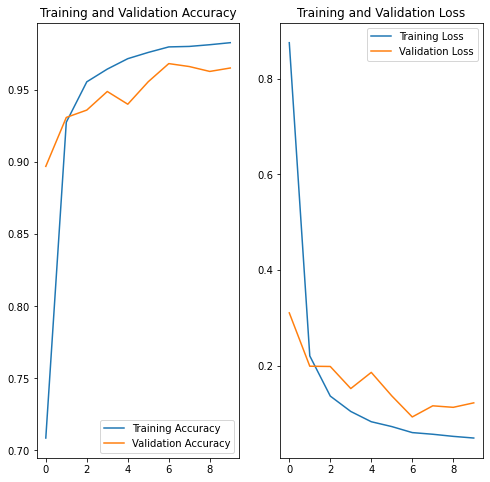

✅


In [18]:
import matplotlib.pyplot as plt

acc1 = history_wav1.history['accuracy']
val_acc1 = history_wav1.history['val_accuracy']

loss1=history_wav1.history['loss']
val_loss1=history_wav1.history['val_loss']

epochs_range1 = range(len(acc1))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range1, acc1, label='Training Accuracy')
plt.plot(epochs_range1, val_acc1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range1, loss1, label='Training Loss')
plt.plot(epochs_range1, val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
print("✅")

## 6. Test dataset을 이용해서 모델의 성능을 평가  
저장한 weight 불러오기  
모델의 예측값과 정답값이 얼마나 일치하는지 확인  

### 6-1. 기본 모델 테스트 결과 : loss 0.09, accuracy 97%

In [18]:
model2.load_weights(checkpoint_dir)
print("✅")

✅


In [19]:
results2 = model2.evaluate(test_dataset)
print("✅")

47/47 [==============================] - 20s 425ms/step - loss: 0.0949 - accuracy: 0.9713
✅


In [20]:
# loss
print("loss value: {:.3f}".format(results2[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results2[1]*100))
print("✅")

loss value: 0.095
accuracy value: 97.1333%
✅


In [21]:
import IPython.display as ipd
import random
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model2(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(130, 126,), rate=8000)

label :  left


In [22]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: left(Correct!)
✅


### 6-2. Skip-Connection 모델 테스트 결과 : loss 0.09, accuracy 96%

In [20]:
model_wav_skip.load_weights(checkpoint_dir)
print("✅")

✅


In [21]:
results1 = model_wav_skip.evaluate(test_dataset)
print("✅")

47/47 [==============================] - 16s 349ms/step - loss: 0.0942 - accuracy: 0.9687
✅


In [22]:
# loss
print("loss value: {:.3f}".format(results1[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results1[1]*100))
print("✅")

loss value: 0.094
accuracy value: 96.8667%
✅


In [25]:
import IPython.display as ipd
import random
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(130, 126,), rate=8000)

label :  yes


In [26]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: yes(Correct!)
✅


# 느낀점

음성으로 데이터를 분석하는 것이 생소하지만 흥미로운 작업이였다.  

1차원 waveform 데이터를 2차원 Spectrogram 데이터로 변경하여 모델을 형성하는 과정에서 차원에 대한 이해와

신경망 layer에 대한 이해가 부족해 어렵게 느껴지기도 했다.   

음성데이터에 대한 정보를 얻을 수 있어서 좋은 시간이였다.   

